In [3]:
import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import mne
from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_gdf
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from EEGModels import EEGNet
from sklearn.metrics import confusion_matrix


'''
Parameters:
'''
tmin = 0
tmax = 3

In [4]:
object_names = ['P03', 'P04', 'P05', 'P06', 'P07', 'P08']
object_names = ['P01']
runMove = [3, 4, 5, 6, 7, 10, 11, 12, 13]
files = []
for name in object_names:
    for i in runMove:
        files.append(read_raw_gdf(f'..\\{name}\\{name} Run {i}.gdf', stim_channel=None, eog=[61,62,63]))

Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 7.gdf...
GDF file dete

C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

In [5]:
print(len(files))

9


In [6]:
eventDescription_offline_paradigm = {
    #'768': "trial start",
    #'785': "beep",
    #'786': "fixation cross",
    '776': "supinationclass cue",
    '777': "pronationclass cue",
    '779': "hand openclass cue",
    '925': "palmar graspclass cue",
    '926': "ateral graspclass cue",
}
# narrow it down to two
eventDescription_offline_paradigm = {
   '779': "hand openclass cue",
   '925': "palmar graspclass cue",
}

In [7]:
# events = [number of events, position, event code, channel, duration]
# file_P01_Run3._raw_extras[0]['events']
event_id = {}
epochs_list = []
for file in files:
    event, _ = mne.events_from_annotations(file)
    # build event id and filter 1-7 id

    contains_both = 0
    for i in _: #handle event_id
        if i not in eventDescription_offline_paradigm:
            continue
        contains_both += 1
        event_id[eventDescription_offline_paradigm[i]] = _[i]


    print(f'event id: {event_id}')
    if contains_both == len(eventDescription_offline_paradigm):
        epochs = mne.Epochs(file, event, event_id, tmin=tmin, tmax=tmax, baseline=None, event_repeated = 'merge', preload=True)
        epochs_list.append(epochs)

result_epochs = mne.concatenate_epochs(epochs_list)

Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
event id: {'hand openclass cue': 11, 'palmar graspclass cue': 14}
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Loading data for 16 events and 769 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
event id: {'hand openclass cue': 11, 'palmar graspclass cue': 14}
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Loading data for 16 events and 769 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']

In [8]:
print(len(set(event_id)))
#9, 10, 0
print(result_epochs.events)

2
[[  4921      0     11]
 [ 12348      0     14]
 [ 14235      0     14]
 [ 22479      0     11]
 [ 27539      0     14]
 [ 34798      0     14]
 [ 38215      0     14]
 [ 43603      0     11]
 [ 48658      0     11]
 [ 50450      0     11]
 [ 54233      0     11]
 [ 56175      0     11]
 [ 57730      0     14]
 [ 59516      0     14]
 [ 67881      0     14]
 [ 71533      0     11]
 [ 77933      0     14]
 [ 83666      0     14]
 [ 88626      0     14]
 [ 94107      0     14]
 [ 95884      0     11]
 [ 97453      0     11]
 [ 99047      0     14]
 [100725      0     11]
 [102510      0     14]
 [115084      0     11]
 [116739      0     11]
 [120328      0     11]
 [123895      0     11]
 [129109      0     11]
 [131114      0     14]
 [147452      0     14]
 [155883      0     14]
 [168382      0     14]
 [175549      0     14]
 [178855      0     14]
 [183912      0     11]
 [187456      0     14]
 [196267      0     11]
 [198195      0     11]
 [200068      0     14]
 [201798      

In [9]:
# 0: not supinationclass or pronationclass cue
labels = result_epochs.events[:,-1]
# labels = np.array(list(map(lambda x:  0 if (not x == 9) else x, labels)))
print(labels)

# format: trials, channels, samples
X = result_epochs.get_data()
y = labels

kernels, chans, samples = 1, X.shape[1], X.shape[2]

[11 14 14 11 14 14 14 11 11 11 11 11 14 14 14 11 14 14 14 14 11 11 14 11
 14 11 11 11 11 11 14 14 14 14 14 14 11 14 11 11 14 14 11 11 11 14 11 11
 14 14 11 14 11 14 11 14 11 14 11 11 11 11 14 14 14 11 14 11 14 14 14 11
 11 11 14 14 14 11 11 11 14 14 14 11 11 14 14 11 11 14 11 14 14 11 11 11
 14 11 14 11 14 14 11 14 14 14 14 11 11 11 11 11 14 11 11 14 14 11 14 14
 14 11 11 14 11 11 11 14 14 14 11 11 14 11 11 14 14 11 14 11 11 14 11 14]


In [10]:
print(np.argmax(result_epochs.get_data()[0]))
print(np.argmax(result_epochs.get_data()[1]))
print(np.argmax(result_epochs.get_data()[2]))



21417
20886
22053


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(Y_train)

[11 14 14 11 14 11 11 11 11 14 14 14 11 11 11 11 14 14 14 11 11 14 11 11
 11 11 11 14 14 14 11 11 14 14 14 11 14 14 11 14 11 14 14 14 14 11 14 14
 11 14 11 11 11 14 14 11 14 14 11 14 11 11 11 14 11 11 14 14 14 14 11 11
 11 14 11 14 11 14 11 14 14 14 11 11 14 11 11 11 14 14 14 14 11 14 14 14
 11 11 11 14 11 11 14 11 14 11 14 11 14 11 11 14 14 14 11]


In [12]:
# Label Encode it first
encoder = OneHotEncoder()
encoder.fit([[x] for x in Y_train])
Y_train = encoder.transform([[x] for x in Y_train]).toarray()
Y_test = encoder.transform([[x] for x in Y_test]).toarray()

# Convert label to one-hot encodings
# Y_train = np_utils.to_categorical(Y_train)
# Y_validate = np_utils.to_categorical(Y_validate)
# Y_test = np_utils.to_categorical(Y_test)

#convert to (trials, kernels, channels, samples) format.
# contains 64 channels and 257 time-points. Set the number of kernels to 1.
X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (115, 1, 64, 769)
115 train samples
29 test samples


In [13]:
print(Y_train)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 

In [14]:
# testing gpu
from tensorflow.python.client import device_lib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
gpus = tf.config.experimental.list_physical_devices('GPU')
for physical_device in gpus:
    tf.config.experimental.set_memory_growth(physical_device, True)
# change the memory fraction as you want...import tensorflow as tf
# if gpus:
#     # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)
print(gpus)

['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
classes_num = len(eventDescription_offline_paradigm)
# configure the EEGNet-8,2,16 model with kernel length of 257 samples (other
# model configurations may do better, but this is a good starting point)
# class num is one
model = EEGNet(nb_classes = classes_num, Chans = chans, Samples = samples,
               dropoutRate = 0.5, kernLength = 128, F1 = 8, D = 2, F2 = 16)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 64, 769)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 64, 769)        1024      
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 64, 769)        32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 1, 769)        1024      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 1, 769)        64        
_________________________________________________________________
activation (Activation)      (None, 16, 1, 769)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 1, 192)       

In [16]:
# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='./checkpoint.h5', verbose=1,
                               save_best_only=True)


In [17]:
# add callback
losses = []
accs = []
class LossAndAccRecord(Callback):
    def on_batch_end(self, batch, logs=None):
        losses.append(logs["loss"])
        accs.append(logs["accuracy"])


    def on_epoch_end(self, epoch, logs=None):
        pass


In [18]:
# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
# unused
class_weights = {0:1, 1:1, 2:1, 3:1}
with tf.device('/device:GPU:0'):
    fittedModel = model.fit(X_train, Y_train, batch_size = 10, epochs = 20,
                        verbose = 1, callbacks=[checkpointer, LossAndAccRecord()])

Epoch 1/20
12/12 [==============================] - 0s 15ms/step - loss: 0.7383 - accuracy: 0.4522
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6984 - accuracy: 0.5304
Epoch 3/20
12/12 [==============================] - 0s 19ms/step - loss: 0.6455 - accuracy: 0.6609
Epoch 4/20
12/12 [==============================] - 0s 10ms/step - loss: 0.6282 - accuracy: 0.6348
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6568 - accuracy: 0.6522
Epoch 6/20
12/12 [==============================] - 0s 18ms/step - loss: 0.6055 - accuracy: 0.6696
Epoch 7/20
12/12 [==============================] - 0s 10ms/step - loss: 0.5688 - accuracy: 0.6957
Epoch 8/20
12/12 [==============================] - 0s 10ms/step - loss: 0.5813 - accuracy: 0.6870
Epoch 9/20
12/12 [==============================] - 0s 10ms/step - loss: 0.6057 - accuracy: 0.6609
Epoch 10/20
12/12 [==============================] - 0s 10ms/step - loss: 0.6093 - accuracy: 0.6087
Epoch 11/20

In [19]:
# load optimal weights
model.load_weights('./checkpoint.h5')

In [20]:
###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
print(probs)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %.4f " % (acc))

[[0.5256974  0.47430262]
 [0.6292368  0.37076312]
 [0.58854145 0.41145858]
 [0.53485024 0.46514973]
 [0.52453    0.47547   ]
 [0.5827999  0.4172001 ]
 [0.57380515 0.42619488]
 [0.5851797  0.41482037]
 [0.5222445  0.47775552]
 [0.58714473 0.41285527]
 [0.6708669  0.32913306]
 [0.5588985  0.44110146]
 [0.6126774  0.3873226 ]
 [0.5368599  0.46314004]
 [0.5840082  0.41599172]
 [0.5441277  0.4558723 ]
 [0.6236153  0.3763847 ]
 [0.5731457  0.42685434]
 [0.5392649  0.46073508]
 [0.55734324 0.44265673]
 [0.56159514 0.43840492]
 [0.50319254 0.49680743]
 [0.523882   0.476118  ]
 [0.50770915 0.49229085]
 [0.53727466 0.46272534]
 [0.5511348  0.44886515]
 [0.5682291  0.43177092]
 [0.556567   0.443433  ]
 [0.57378113 0.42621884]]
Classification accuracy: 0.5172 


In [23]:
confusion_matrix(Y_test.argmax(axis=-1), preds)

array([[15,  0],
       [14,  0]], dtype=int64)

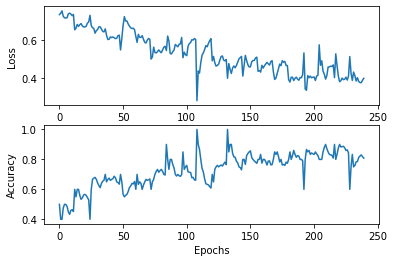

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)
ax[0].plot(losses)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[1].plot(accs)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
plt.show()